In [2]:
import pymc3 as pm

In [3]:
import pandas as pd

In [ ]:
hist_log_lags = pd.read_excel('hist_log_lags.xlsx')

In [ ]:
hist_log_lags

## Bayesian Regression

### 1 variable: ETC_lag4

In [ ]:
formula = 'ETH ~ 0 + ETC_lag4'

In [ ]:
with pm.Model() as model_1:
    pm.GLM.from_formula(formula, data=hist_log_lags)
    trace_1 = pm.sample(draws=1000, tune=500,chains=4)

In [ ]:
pm.traceplot(trace_1)

In [ ]:
pm.forestplot(trace_1)

In [ ]:
pm.summary(trace_1)

### 2 variable: ETC_lag1 and ETC_lag4

In [ ]:
formula2 = 'ETH ~ 0 + ETC_lag1 + ETC_lag4'

In [ ]:
with pm.Model() as model_2:
    pm.GLM.from_formula(formula2, data=hist_log_lags)
    trace_2 = pm.sample(draws=1000, tune=500,chains=4)

In [ ]:
pm.traceplot(trace_2)

In [ ]:
pm.forestplot(trace_2)

In [ ]:
pm.summary(trace_2)

### Comparison

In [ ]:
comparison = pm.compare({"trace_1": trace_1, "trace_2": trace_2},
                        ic="waic", scale="deviance")

In [ ]:
comparison

In [ ]:
pm.compareplot(comparison)

## Loess Decomposition

In [4]:
hist = pd.read_excel('hist_df.xlsx',index_col=0)

In [5]:
hist_ether = hist[['ETH','ETC']]

In [ ]:
hist_ether.head(3)

In [6]:
import datetime as dt

In [7]:
# weekly
hist_ether = hist_ether[hist_ether.index.weekday==4]
hist_ether.head(3)

,ETH,ETC
Date,,
2019-01-04,154.581940,5.254148
2019-01-11,127.548325,4.485956
2019-01-18,121.010262,4.384914


In [8]:
import numpy as np

In [9]:
hist_ether_log = np.log(hist_ether)
hist_ether_log.head(3)

,ETH,ETC
Date,,
2019-01-04,5.040724,1.659018
2019-01-11,4.848495,1.500952
2019-01-18,4.795875,1.478170


In [10]:
from statsmodels.tsa.seasonal import STL

In [11]:
stl = STL(hist_ether_log[['ETH']],period=12) # every 12 weeks makes a Quarter
stl_fit = stl.fit()

In [12]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [ ]:
stl_fit.plot()

In [ ]:
stl_fit.trend.plot(title='log_ETH Loess Decomp Trend Component')

### Structural Break (Chow Test)

###### from PyPi

In [ ]:
# from PyPi
from chow_test import chowtest as ct

In [14]:
t = pd.Series(list(range( 0+1 , len(stl_fit.trend)+1 ) ) ).values
display(t.shape)
t

(141,)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141], dtype=int64)

In [15]:
X = pd.DataFrame(t,columns=['Time'])
X

,Time
0,1
1,2
2,3
3,4
4,5
...,...
136,137
137,138
138,139
139,140


In [16]:
y = pd.DataFrame(stl_fit.trend.values,columns=['Trend'])
y

,Trend
0,4.758630
1,4.775737
2,4.793088
3,4.810536
4,4.828002
...,...
136,8.033696
137,8.081537
138,8.130480
139,8.180327


In [ ]:
plt.plot(t,stl_fit.trend.values)

In [ ]:
stl_fit.trend.index[25]

In [ ]:
# around late June 2019
ct(X[:50],y[:50],
   last_index_in_model_1=25,
   first_index_in_model_2=26,
   significance_level = .05) #.residuals

In [ ]:
stl_fit.trend.index[50]

In [ ]:
# around late Dec 2019
ct(X[25:70],y[25:70],
   last_index_in_model_1=50,
   first_index_in_model_2=50,
   significance_level = .05) #.residuals

###### from GitHub jkclem

In [ ]:
import chowtest as cht

In [ ]:
cht.linear_residuals(X,y)

In [ ]:
cht.calculate_RSS(X,y)

In [ ]:
cht.ChowTest(X,y,last_index_in_model_1=X.index[50], first_index_in_model_2=X.index[50]+1)

## Hierarchical Model

In [17]:
stl_trend_df = X.join(y,how='left')
stl_trend_df

,Time,Trend
0,1,4.758630
1,2,4.775737
2,3,4.793088
3,4,4.810536
4,5,4.828002
...,...,...
136,137,8.033696
137,138,8.081537
138,139,8.130480
139,140,8.180327


In [ ]:
stl_trend_df[40:60]

In [ ]:
stl_trend_df = stl_trend_df.drop('Regime',axis=1)

In [73]:
stl_trend_df['Regime'] = np.where(stl_trend_df.index<=25,0,
                                 np.where(stl_trend_df.index<=49,1,
                                         np.where(stl_trend_df.index>49,2,3)
                                         )
                                 )

In [74]:
type(stl_trend_df.Regime[0])

numpy.int32

In [75]:
stl_trend_df[20:30]

,Time,Trend,Regime
20,21,5.416527,0
21,22,5.462976,0
22,23,5.501451,0
23,24,5.530141,0
24,25,5.546541,0
25,26,5.548552,0
26,27,5.536080,1
27,28,5.510876,1
28,29,5.476171,1
29,30,5.435516,1


In [76]:
stl_trend_df[45:55]

,Time,Trend,Regime
45,46,5.088102,1
46,47,5.063178,1
47,48,5.043199,1
48,49,5.029419,1
49,50,5.022853,1
50,51,5.025179,2
51,52,5.039411,2
52,53,5.066154,2
53,54,5.102537,2
54,55,5.143068,2


In [77]:
regime_id = stl_trend_df.Regime.values
regime_id

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [47]:
n_reg = len(stl_trend_df.Regime.unique())
n_reg

3

In [ ]:
from pymc3 import *

In [134]:
with pm.Model() as hierarchical_model:
    
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    
    mu_b = pm.Normal('mu_beta', mu=0., sigma=100)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=100)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_reg)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=n_reg)
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    radon_est = a[regime_id] + b[regime_id] * stl_trend_df.Time 
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sigma=eps, observed=stl_trend_df.Trend)

In [136]:
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=1000, tune=500,chains=4)

<ipython-input-136-fddab8153153>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(draws=1000, tune=500,chains=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 90 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8954580347740768, but should be close to 0.8. Try to increase the number of tuning steps.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-137-bea842d6d01d>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace)
C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002025942F370>,
      dtype=object)

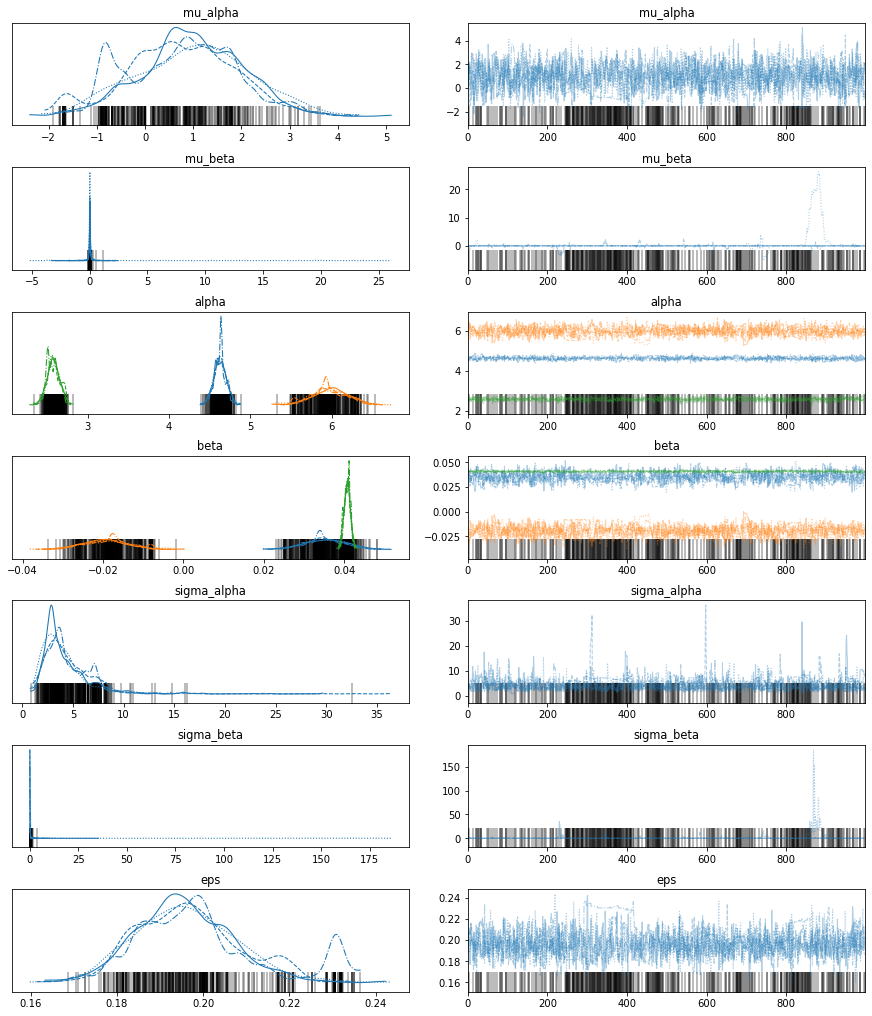

In [137]:
pm.traceplot(hierarchical_trace)

<ipython-input-138-14042157f4ac>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(hierarchical_trace)
C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002025BB7B610>],
      dtype=object)

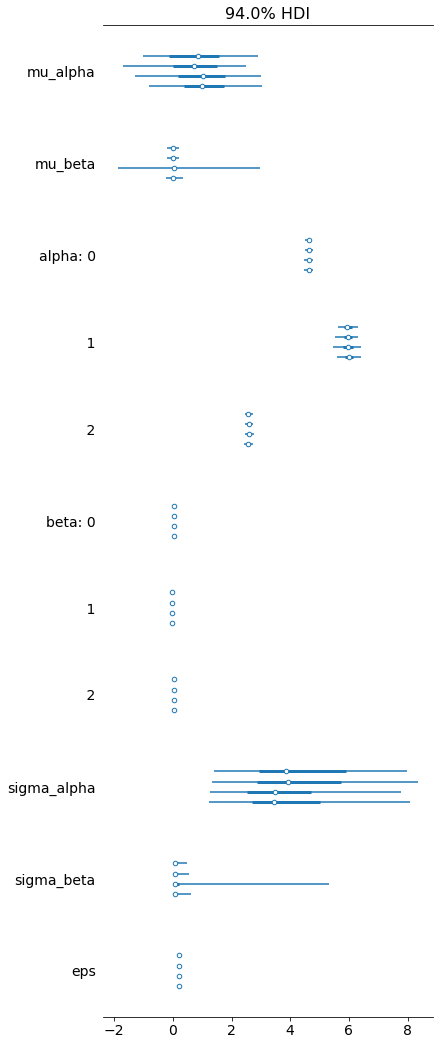

In [138]:
pm.forestplot(hierarchical_trace)

In [139]:
pm.summary(hierarchical_trace)

C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,0.871,1.127,-1.128,3.053,0.064,0.045,328.0,389.0,1.01
mu_beta,0.185,1.820,-0.332,0.413,0.182,0.129,496.0,149.0,1.01
alpha[0],4.629,0.076,4.486,4.773,0.003,0.002,723.0,1127.0,1.01
alpha[1],5.973,0.223,5.520,6.349,0.011,0.008,447.0,178.0,1.02
alpha[2],2.580,0.078,2.450,2.735,0.003,0.002,499.0,873.0,1.01
beta[0],0.035,0.005,0.026,0.045,0.000,0.000,618.0,741.0,1.00
beta[1],-0.019,0.006,-0.029,-0.008,0.000,0.000,431.0,165.0,1.02
beta[2],0.041,0.001,0.039,0.042,0.000,0.000,516.0,1305.0,1.01
sigma_alpha,4.301,2.478,1.318,8.196,0.116,0.082,418.0,1223.0,1.01
sigma_beta,0.658,5.670,0.016,0.866,0.403,0.285,187.0,159.0,1.02


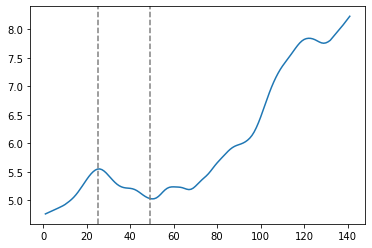

In [85]:
plt.plot(stl_trend_df['Time'],stl_trend_df['Trend'])
for break_point in [25,49]:
    plt.axvline(break_point,color='grey',linestyle='dashed')

#### Bayesian Regression of all ts

In [172]:
formula = 'Trend ~ Time'
with pm.Model() as model_1:
    pm.GLM.from_formula(formula, data=stl_trend_df[['Time','Trend']])
    trace_ = pm.sample(draws=1000, tune=500,chains=4)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
<ipython-input-172-4796d6a36fe7>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ = pm.sample(draws=1000, tune=500,chains=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, Time, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.8803443954143515, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9010166270140696, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9116118588491827, but should be close to 0.8. Try to increase the number of tuning steps.


<ipython-input-173-2b4891f74a2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_)
C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020257DF6D30>,
      dtype=object)

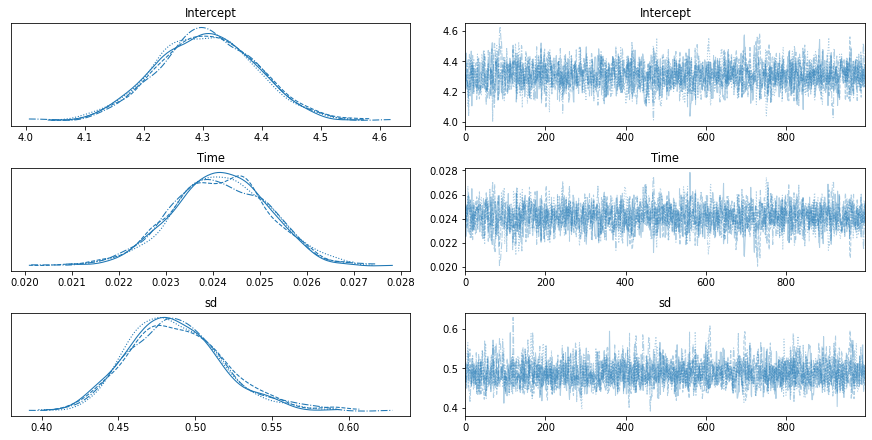

In [173]:
pm.traceplot(trace_)

<ipython-input-174-8b8089fb109f>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace_)
C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000202571E6400>],
      dtype=object)

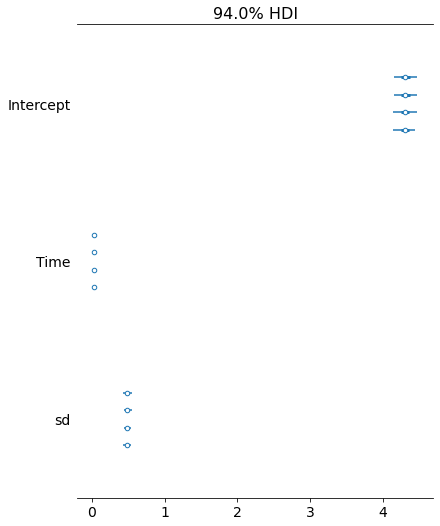

In [174]:
pm.forestplot(trace_)

In [175]:
pm.summary(trace_)

C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.307,0.084,4.138,4.455,0.002,0.002,1526.0,1380.0,1.0
Time,0.024,0.001,0.022,0.026,0.000,0.000,1530.0,1715.0,1.0
sd,0.487,0.031,0.431,0.545,0.001,0.000,2267.0,1927.0,1.0


### Comparing with Frequentist Regression

In [146]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [148]:
for regime in stl_trend_df.Regime.unique():
    y = stl_trend_df[stl_trend_df['Regime']==regime][['Trend']]
    x = stl_trend_df[stl_trend_df['Regime']==regime][['Time' ]]
    x = sm.add_constant(x)
    
    model = OLS(endog=y,exog=x,hasconst=True)
    model = model.fit()
    print('=== Regime '+str(regime)+' ===')
    print(model.summary() )
    print('\n')

=== Regime 0 ===
                            OLS Regression Results                            
Dep. Variable:                  Trend   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     624.1
Date:                Tue, 05 Oct 2021   Prob (F-statistic):           1.09e-18
Time:                        17:08:24   Log-Likelihood:                 40.079
No. Observations:                  26   AIC:                            -76.16
Df Residuals:                      24   BIC:                            -73.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6297      0.022   

In [149]:
print('=== All Time Series ===')
y=stl_trend_df['Trend']
x=stl_trend_df['Time']
x=sm.add_constant(x)

ols = OLS(endog=y,exog=x,hasconst=True)
ols = ols.fit()
ols.summary()

=== All Time Series ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Trend   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     583.9
Date:                Tue, 05 Oct 2021   Prob (F-statistic):           1.29e-51
Time:                        17:09:43   Log-Likelihood:                -96.359
No. Observations:                 141   AIC:                             196.7
Df Residuals:                     139   BIC:                             202.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3085      0.082     52.714      0.000       4.147       4.470
Time           0.0241      0.001     24.164      0.000       0.022       0.026
==============================================================================
Omnibus:                     1881.073   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.442
Skew:                          -0.192   Prob(JB):                     0.000269
Kurtosis:                       1.372   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Conclusion

In [176]:
bayesian_trend_intercept = pm.summary(trace_).loc['Intercept','mean']
bayesian_trend_slope = pm.summary(trace_).loc['Time','mean']

C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [166]:
bayesian_trend_slope

0.185

In [155]:
frequentist_trend_intercept = ols.params[0]
frequentist_trend_slope = ols.params[1]

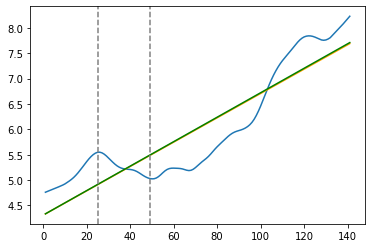

In [177]:
plt.plot(stl_trend_df['Time'],stl_trend_df['Trend'])
plt.plot(stl_trend_df['Time'],stl_trend_df['Time']*bayesian_trend_slope+bayesian_trend_intercept,color='orange')
plt.plot(stl_trend_df['Time'],stl_trend_df['Time']*frequentist_trend_slope+frequentist_trend_intercept,color='green')

for break_point in [25,49]:
    plt.axvline(break_point,color='grey',linestyle='dashed')

In [152]:
ols.params[0]

4.30846915886332